In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# to make torch.use_deterministic_algorithms(True) work
os.environ.update({'CUBLAS_WORKSPACE_CONFIG': ':4096:8'})

In [3]:
from pathlib import Path

import pandas as pd
import torch

from src.augmentations import DefaultWaveAugmentations, DefaultWave2Spec
from src.configs import DefaultConfig, DistillationConfig
from src.data_utils import get_dataloaders, SpeechCommandsDataset
from src.models import CRNN
from src.trainers import DefaultTrainer, DistillationTrainer
from src.utils import count_parameters, seed_all

In [4]:
DATA_DIR = Path('data/speech_commands')
TRAIN_CSV = Path('data/train.csv')
VAL_CSV = Path('data/val.csv')

STUDENT_CHECKPOINT = Path('checkpoints/distillated.pth')
TEACHER_CHECKPOINT = Path('checkpoints/baseline.pth')

In [5]:
train_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(TRAIN_CSV))
train_set.transforms = DefaultWaveAugmentations(DATA_DIR)

val_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(VAL_CSV))
train_loader, val_loader = get_dataloaders(train_set, val_set, DefaultConfig.batch_size)

train_wave2spec = DefaultWave2Spec(is_train=True, config=DefaultConfig)
val_wave2spec = DefaultWave2Spec(is_train=False, config=DefaultConfig)

In [6]:
teacher_config = DefaultConfig()
student_config = DistillationConfig(
    num_epochs=30,
    hidden_size=32,
)

In [7]:
teacher = CRNN(teacher_config)
teacher.load_state_dict(torch.load(TEACHER_CHECKPOINT, map_location=teacher_config.device))
teacher = teacher.eval()
print('teacher total:', count_parameters(teacher))
print('teacher conv:', count_parameters(teacher.conv))
print('teacher gru:', count_parameters(teacher.gru))
print('teacher attention:', count_parameters(teacher.attention), end='\n\n')

student = CRNN(student_config)
student = student.train()
print('student total:', count_parameters(student))
print('student conv:', count_parameters(student.conv))
print('student gru:', count_parameters(student.gru))
print('student attention:', count_parameters(student.attention))

teacher total: 70443
teacher conv: 808
teacher gru: 65280
teacher attention: 4225

student total: 25387
student conv: 808
student gru: 23424
student attention: 1089


Проверим, что модель учителя воспроизводит нужное качество на валидации:

In [8]:
seed_all()
DefaultTrainer(
    opt=None,
    train_loader=None,
    val_loader=val_loader,
    device=teacher_config.device,
    model=teacher,
    train_wave2spec=None,
    val_wave2spec=val_wave2spec,
).validation()

100%|██████████| 102/102 [00:07<00:00, 12.78it/s]


1.71149264626571e-05

Теперь сделаем дистилляцию:

In [9]:
opt = torch.optim.Adam(
    student.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

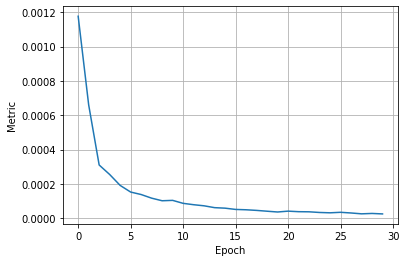

END OF EPOCH 30


[0.0011762036282390916,
 0.0006606821115749386,
 0.0003103333606348635,
 0.00025506790248609523,
 0.00019144191017617543,
 0.00015279905581462174,
 0.0001383933959537939,
 0.00011721456958839288,
 0.00010211965798194549,
 0.00010438434228898117,
 8.707248675614705e-05,
 7.911476205672125e-05,
 7.266981066910978e-05,
 6.194612766583405e-05,
 5.899517538696936e-05,
 5.16192865767029e-05,
 4.9614190589446e-05,
 4.599487298149568e-05,
 4.122381869038886e-05,
 3.6691466302526904e-05,
 4.164154702106738e-05,
 3.850858454097848e-05,
 3.7792478831243875e-05,
 3.390760535593363e-05,
 3.195621729690683e-05,
 3.4901202028190404e-05,
 3.095068552948782e-05,
 2.601253990610959e-05,
 2.8220532511124627e-05,
 2.5511265909295366e-05]

In [10]:
seed_all()
trainer = DistillationTrainer(
    opt=opt,
    train_loader=train_loader,
    val_loader=val_loader,
    device=student_config.device,
    teacher=teacher,
    student=student,
    train_wave2spec=train_wave2spec,
    val_wave2spec=val_wave2spec,
    temp=student_config.temp,
    alpha=student_config.alpha,
)
trainer.train(n_epochs=student_config.num_epochs)

In [11]:
if not STUDENT_CHECKPOINT.parent.exists():
    STUDENT_CHECKPOINT.parent.mkdir()
torch.save(trainer.best_state, str(STUDENT_CHECKPOINT))

In [12]:
trainer.best_score

2.5511265909295366e-05